In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scanpy as sc
import anndata as ad
import os
from scipy.io import mmread

In [22]:

def create_anndata_from_seurat_export(base_path):
    """
    Create an AnnData object from Seurat exported files with SCT as the main layer.
    
    Parameters:
    -----------
    base_path : str
        Base path to the directory containing the exported files
    
    Returns:
    --------
    adata : AnnData
        Annotated data matrix
    """
    # Load SCT data as main layer
    sct_normalized = sp.csr_matrix(sio.mmread(f"{base_path}/sct_normalized.mtx"))
    sct_genes = pd.read_csv(f"{base_path}/genes_sct.tsv", header=None)[0].values
    barcodes = pd.read_csv(f"{base_path}/barcodes.tsv", header=None)[0].values
    
    print(f"SCT normalized matrix shape: {sct_normalized.shape}")
    
    # Create base AnnData object using SCT normalized data
    adata = sc.AnnData(sct_normalized.T, 
                      var=pd.DataFrame(index=sct_genes),
                      obs=pd.DataFrame(index=barcodes))
    
    # Load variable features first
    var_features = pd.read_csv(f"{base_path}/variable_features.tsv", header=None)[0].values
    print(f"Number of variable features: {len(var_features)}")
    
    # Load scaled genes and verify if they match variable features
    scaled_genes = pd.read_csv(f"{base_path}/genes_sct_scaled.tsv", header=None)[0].values
    print(f"Number of scaled genes: {len(scaled_genes)}")
    
    # Check if scaled genes match variable features
    scaled_set = set(scaled_genes)
    var_features_set = set(var_features)
    if scaled_set == var_features_set:
        print("Scaled genes match variable features exactly")
    else:
        print(f"Number of genes in common between scaled and variable: {len(scaled_set.intersection(var_features_set))}")
    
    # Mark highly variable genes in var
    adata.var['highly_variable'] = adata.var_names.isin(var_features)
    
    # Load scaled data
    sct_scaled = sp.csr_matrix(sio.mmread(f"{base_path}/sct_scaled.mtx"))
    print(f"SCT scaled matrix shape: {sct_scaled.shape}")

    print("Number of highly variable genes:", adata.var['highly_variable'].sum())
    
    # Create a subset of the main AnnData with only variable features
    adata_hvg = adata[:, adata.var['highly_variable']].copy()
    
    # Store the scaled data for these genes
    if sct_scaled.shape[1] == sum(adata.var['highly_variable']):
        adata_hvg.X = sct_scaled.T
        adata.uns['scaled_hvg'] = adata_hvg
        print("Stored scaled data for highly variable genes in adata.uns['scaled_hvg']")
    else:
        print(f"Warning: scaled matrix shape doesn't match number of variable features")
    
    # Store raw RNA counts
    rna_counts = sp.csr_matrix(sio.mmread(f"{base_path}/rna_counts.mtx"))
    genes_rna = pd.read_csv(f"{base_path}/genes_rna.tsv", header=None)[0].values
    
    print(f"RNA matrix shape: {rna_counts.shape}")
    
    # Create raw AnnData with RNA counts
    adata_raw = sc.AnnData(rna_counts.T,
                          var=pd.DataFrame(index=genes_rna),
                          obs=pd.DataFrame(index=barcodes))
    
    # Store raw counts
    adata.raw = adata_raw
    
    # Load SCT counts
    sct_counts = sp.csr_matrix(sio.mmread(f"{base_path}/sct_counts.mtx"))
    if sct_counts.shape == sct_normalized.shape:
        adata.layers['counts'] = sct_counts.T
    
    # Load metadata
    metadata = pd.read_csv(f"{base_path}/metadata.csv", index_col=0, low_memory=False)
    common_cells = adata.obs_names.intersection(metadata.index)
    adata = adata[common_cells].copy()
    metadata = metadata.loc[common_cells]
    adata.obs = metadata
    
    # Load dimensionality reductions
    reduction_files = {
        'X_pca': 'pca.csv',
        'X_harmony': 'harmony_rna.csv',
        'X_umap': 'umap.csv',
        'X_rna_umap': 'rna.umap.csv',
        'X_sct_wnn_umap': 'sct.dsb_wnn_umap.csv',  # Added SCT WNN UMAP
        'X_sctpca': 'sctpca.csv',  # Added SCT PCA
        'X_adt_umap': 'adt.umap.csv',  # ADT UMAP
        'X_adt_pca': 'adtpca.csv'  # ADT PCA
    }
    
    for reduction, filename in reduction_files.items():
        try:
            data = pd.read_csv(f"{base_path}/{filename}", index_col=0)
            data = data.loc[adata.obs_names]  # Ensure matching order
            adata.obsm[reduction] = data.values
            print(f"Loaded {reduction} from {filename}")
        except Exception as e:
            print(f"Could not load {filename}: {str(e)}")

    print("sct_genes length:", len(sct_genes))   # Should be number of genes
    print("barcodes length:", len(barcodes))     # Should be number of cells
    print("sct_normalized shape before transpose:", sct_normalized.shape)
    print("sct_normalized shape after transpose:", sct_normalized.T.shape)
    
    return adata

# Usage
base_path = '/data/norman/southark/external_datasets/fibro_atlas_cardiac_nature_2024/seurat_to_matrix'
adata = create_anndata_from_seurat_export(base_path)

# Save the AnnData object
adata.write_h5ad(f"{base_path}/fibroblast_atlas.h5ad")

SCT normalized matrix shape: (22516, 34910)
Number of variable features: 3000
Number of scaled genes: 3000
Scaled genes match variable features exactly
SCT scaled matrix shape: (3000, 34910)
Number of highly variable genes: 3000
RNA matrix shape: (23944, 34910)
Loaded X_pca from pca.csv
Loaded X_harmony from harmony_rna.csv
Loaded X_umap from umap.csv
Loaded X_rna_umap from rna.umap.csv
Loaded X_sct_wnn_umap from sct.dsb_wnn_umap.csv
Loaded X_sctpca from sctpca.csv
Loaded X_adt_umap from adt.umap.csv
Loaded X_adt_pca from adtpca.csv
sct_genes length: 22516
barcodes length: 34910
sct_normalized shape before transpose: (22516, 34910)
sct_normalized shape after transpose: (34910, 22516)


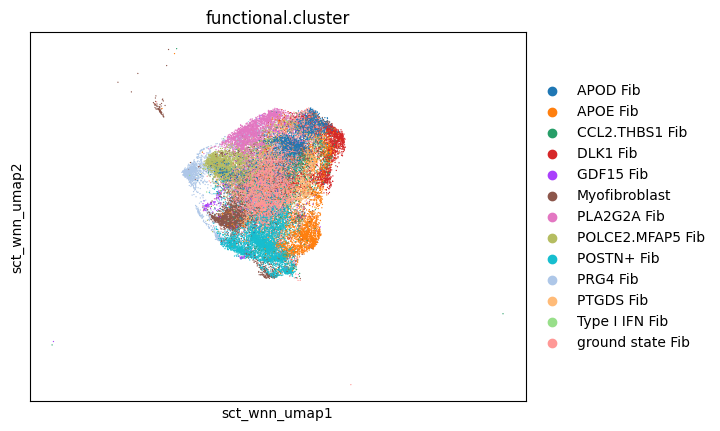

In [16]:
sc.pl.embedding(adata, 'sct_wnn_umap', color='functional.cluster')

In [17]:
# First, let's see what metadata columns we have available to color the cells
print("Available metadata columns:")
print(adata.obs.columns.tolist())

# Let's see which UMAP representations we have
print("\nAvailable UMAP embeddings:")
print([key for key in adata.obsm.keys() if 'umap' in key.lower()])

Available metadata columns:
['sample', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'propmt', 'rna_size', 'ngene', 'prot_size', 'bc', 'droplet_class', 'nCount_ADT', 'nFeature_ADT', 'nCount_CITE', 'nFeature_CITE', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'CITE.weight', 'sct.dsb_snn_res.0.1', 'sct.dsb_snn_res.0.2', 'sct.dsb_snn_res.0.3', 'sct.dsb_snn_res.0.4', 'sct.dsb_snn_res.0.5', 'sct.dsb_snn_res.0.6', 'sct.dsb_snn_res.0.7', 'sct.dsb_snn_res.0.8', 'seurat_clusters', 'annotation.0.1', 'celltype', 'Sample.name', 'Date.of.harvest', 'HF.etiology', 'Txp.LVAD', 'Race', 'Sex', 'Age', 'time.since.last.ischemic.event', 'BMI', 'HTN', 'DM', 'MI', 'Stent', 'CABG', 'CKD', 'Smoker', 'EF', 'CO', 'Intermacs..profile.1....profile.2...2..profile.3.3..profile.4.4..profile.5.5.', 'Atrial.arrh', 'Ventricular.arrh', 'MR', 'MS', 'AR', 'AS', 'Pacemaker', 'ICD', 'Temp.mech.support..pre.op.', 'Durable.mech.support..pre.op', 'GDMT', 'Inotropes', 'SCT_snn_res.0.1', 'SCT_snn_res.0.2', 'SCT_snn_res.0.3', 'predic

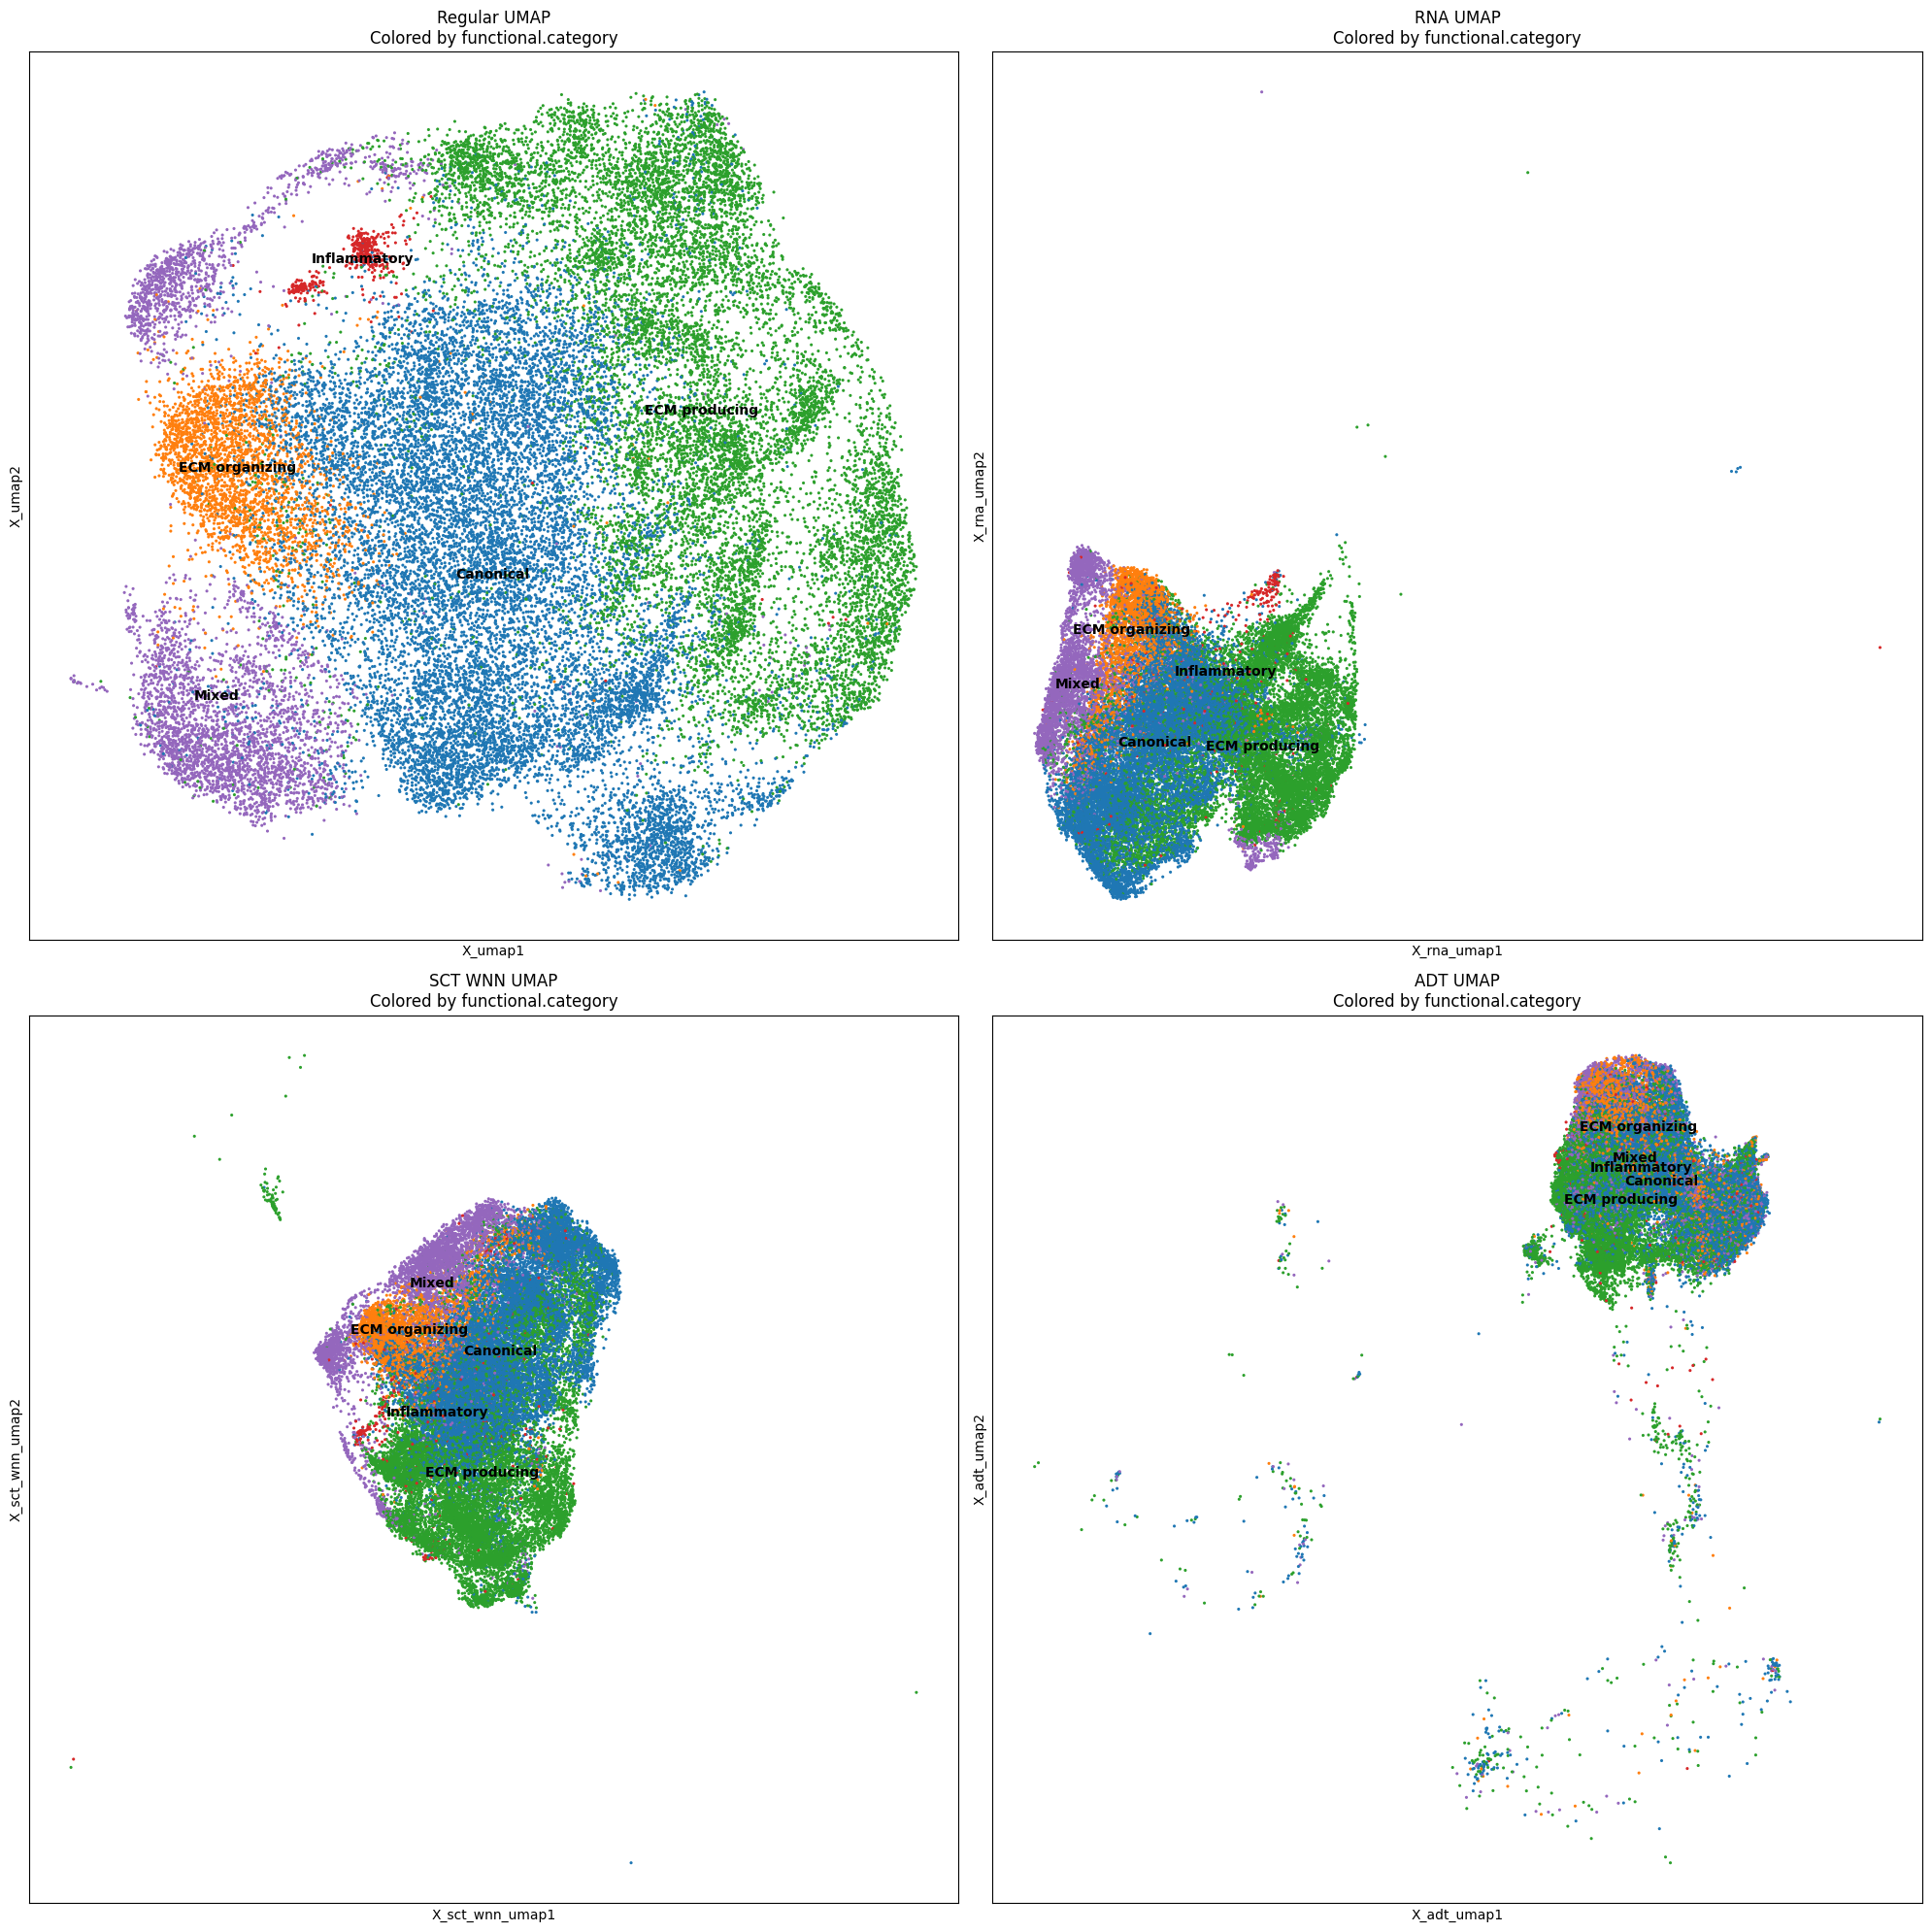


Cell type distribution:
functional.category
Canonical         15081
ECM producing     12421
Mixed              4085
ECM organizing     2903
Inflammatory        420
Name: count, dtype: int64


In [18]:
import matplotlib.pyplot as plt

# Set up the figure
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.flatten()

# List of UMAP embeddings and their titles
umaps = [
    ('X_umap', 'Regular UMAP'),
    ('X_rna_umap', 'RNA UMAP'),
    ('X_sct_wnn_umap', 'SCT WNN UMAP'),
    ('X_adt_umap', 'ADT UMAP')
]

# Color by functional category
color_column = 'functional.category'

# Plot each UMAP
for ax, (umap_key, title) in zip(axes, umaps):
    sc.pl.embedding(
        adata,
        basis=umap_key,
        color=color_column,
        ax=ax,
        title=f"{title}\nColored by {color_column}",
        show=False,
        size=20,
        legend_loc='on data'
    )

plt.tight_layout()
plt.show()

# Let's also look at some key statistics about the cell populations
print("\nCell type distribution:")
print(adata.obs[color_column].value_counts())

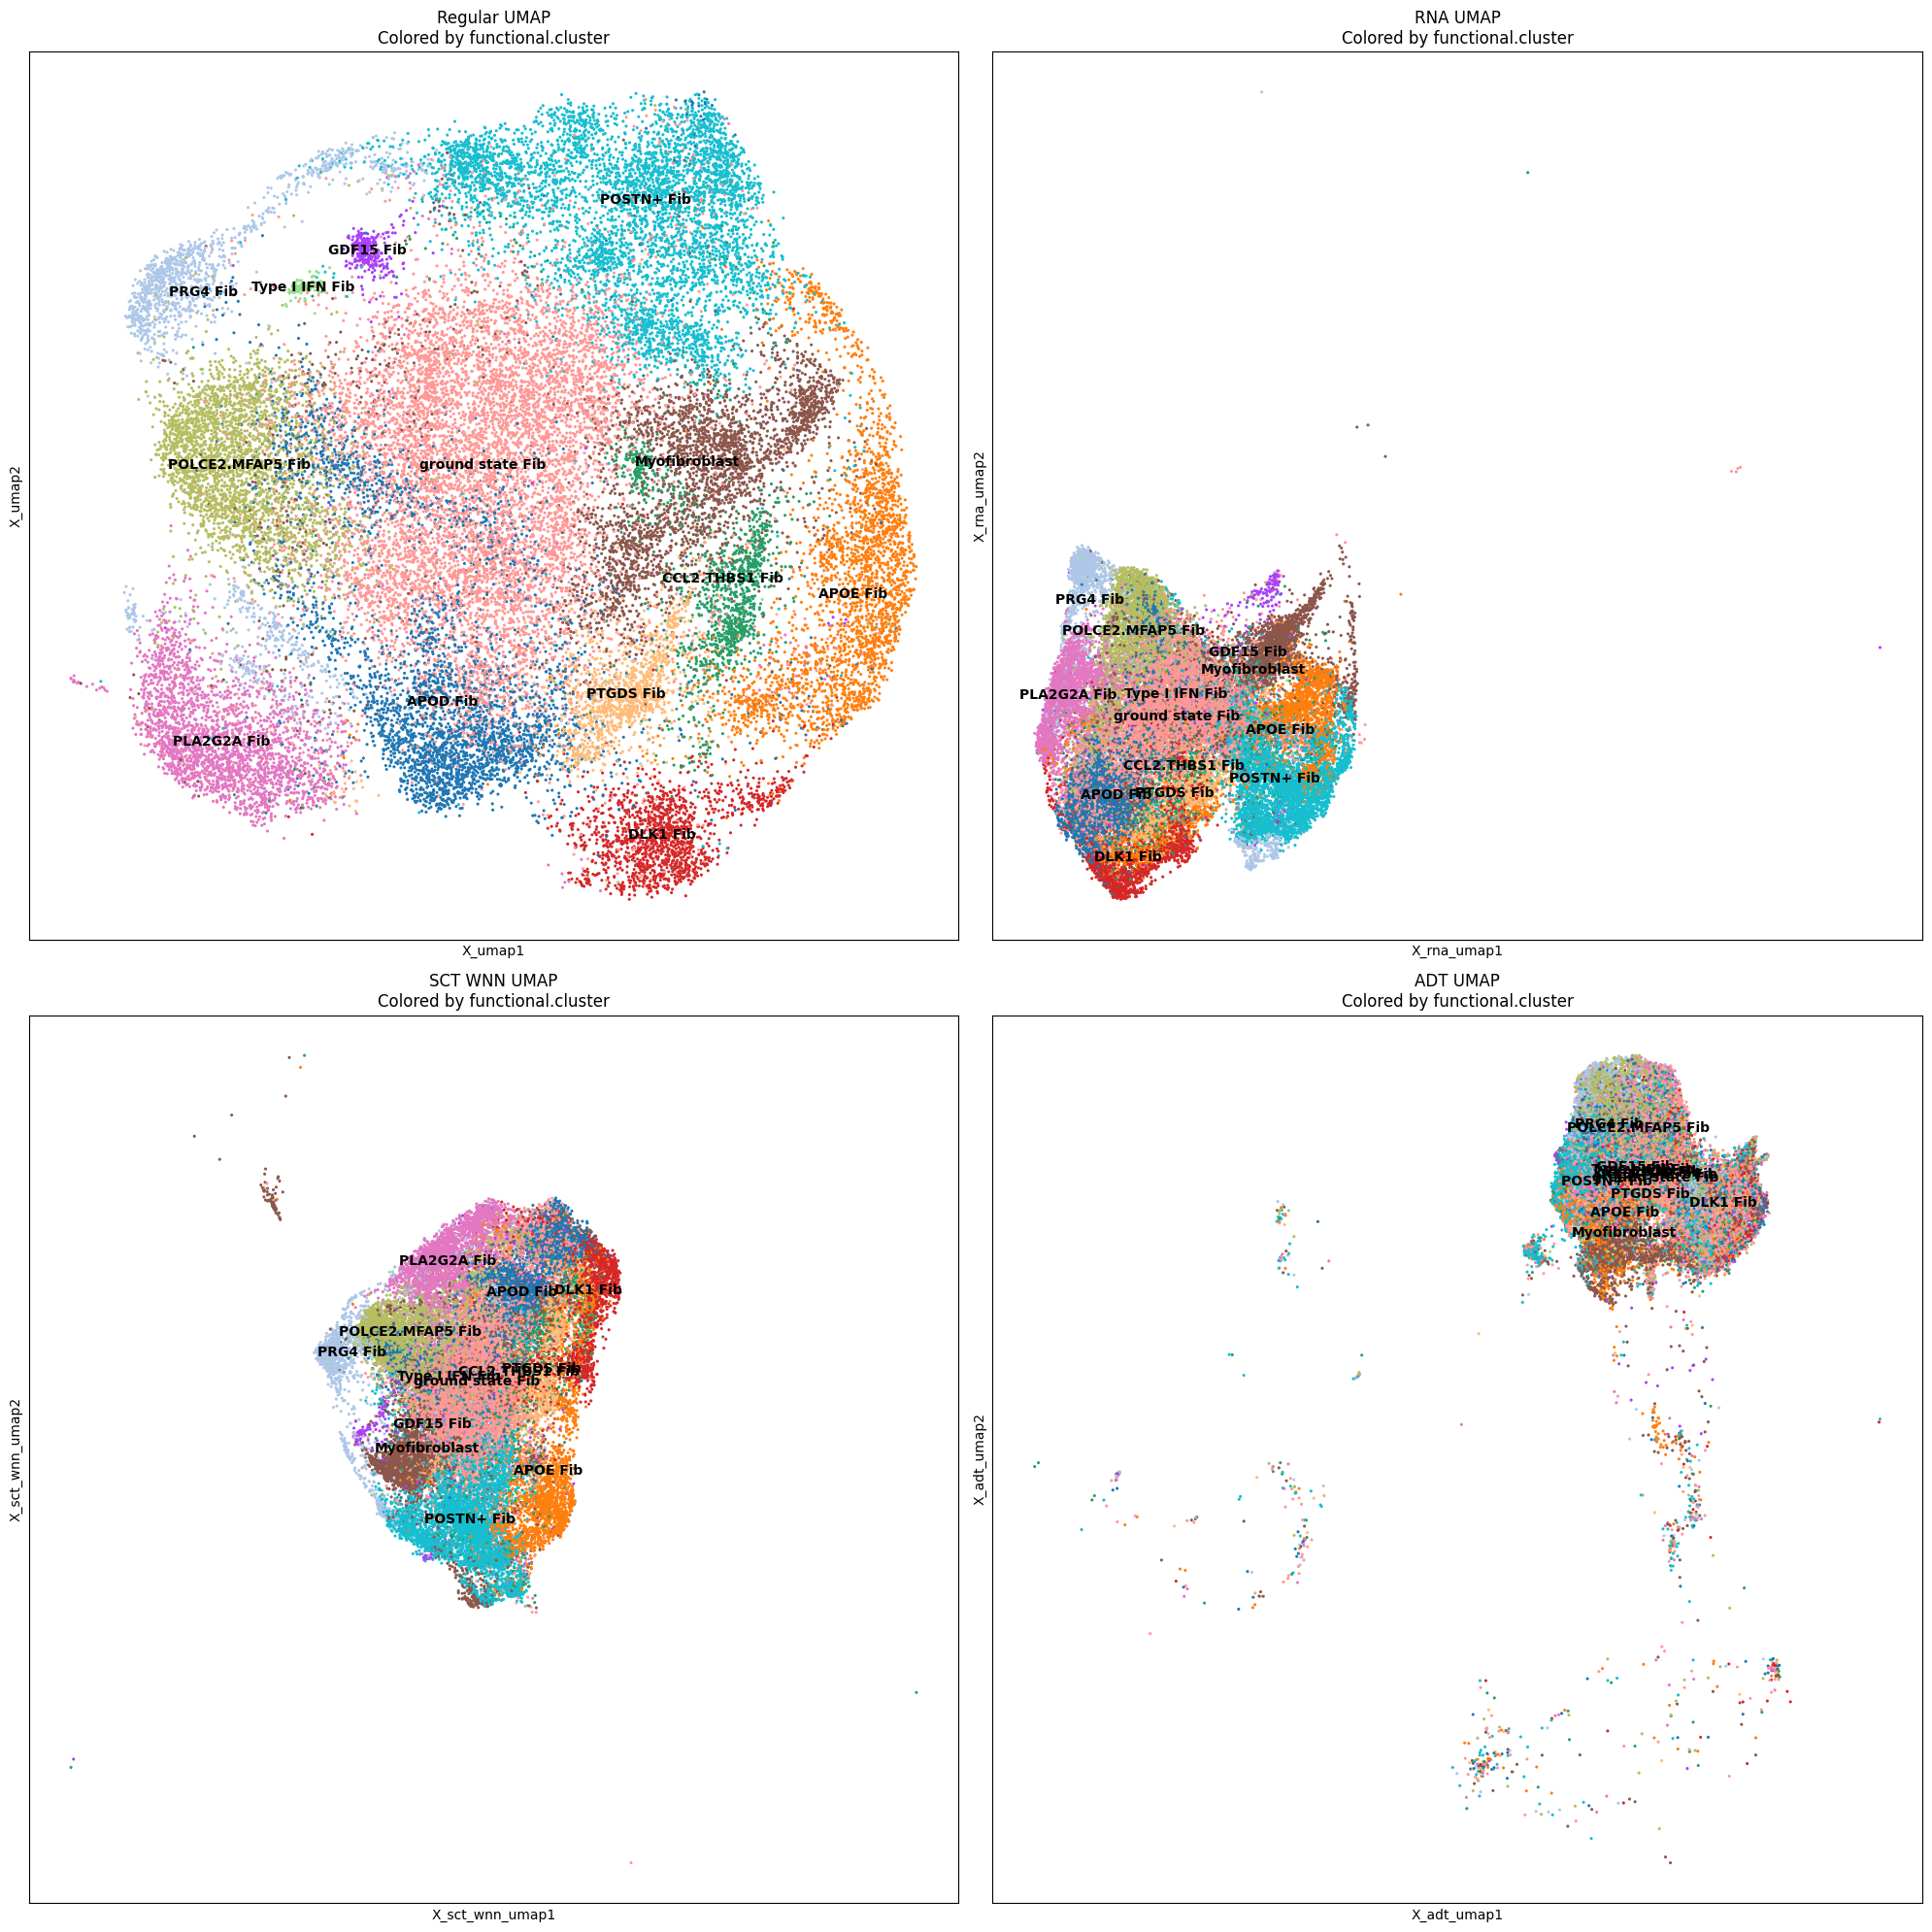


Cell type distribution:
functional.cluster
ground state Fib    8534
POSTN+ Fib          5034
APOD Fib            3639
Myofibroblast       3335
POLCE2.MFAP5 Fib    3058
APOE Fib            2727
PLA2G2A Fib         2518
PRG4 Fib            1539
DLK1 Fib            1408
CCL2.THBS1 Fib      1382
PTGDS Fib           1310
GDF15 Fib            311
Type I IFN Fib       115
Name: count, dtype: int64


In [19]:
# Set up the figure
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.flatten()

# List of UMAP embeddings and their titles
umaps = [
    ('X_umap', 'Regular UMAP'),
    ('X_rna_umap', 'RNA UMAP'),
    ('X_sct_wnn_umap', 'SCT WNN UMAP'),
    ('X_adt_umap', 'ADT UMAP')
]

# Color by functional category
color_column = 'functional.cluster'

# Plot each UMAP
for ax, (umap_key, title) in zip(axes, umaps):
    sc.pl.embedding(
        adata,
        basis=umap_key,
        color=color_column,
        ax=ax,
        title=f"{title}\nColored by {color_column}",
        show=False,
        size=20,
        legend_loc='on data'
    )

plt.tight_layout()
plt.show()

# Let's also look at some key statistics about the cell populations
print("\nCell type distribution:")
print(adata.obs[color_column].value_counts())